# Классификация: Превышение медианного значения SI

Цель задачи: разработать модель машинного обучения для предсказания, превышает ли значение **SI** (селективный индекс) медианное значение выборки. Задача сводится к бинарной классификации, где целевая переменная определяется на основе медианы SI.

## Описание данных
- **IC50, mM**: Полумаксимальная ингибирующая концентрация.
- **CC50, mM**: Полумаксимальная цитотоксическая концентрация.
- **SI**: Селективный индекс, вычисляемый как отношение CC50 к IC50.
- **Дескрипторы молекул**: Числовые характеристики (MaxAbsEStateIndex, MolWt, qed и др.), описывающие физико-химические свойства соединений.

## Этапы работы
1. **Предобработка данных**: Загрузка данных из xlsx, удаление константных признаков, обработка пропусков медианным значением, масштабирование признаков.
2. **Сравнение моделей**: Обучение и оценка логистической регрессии, случайного леса, XGBoost и LightGBM с визуализацией метрик.
3. **Оптимизация гиперпараметров**: Настройка лучшей модели с помощью GridSearchCV.
4. **Анализ важности признаков**: Определение наиболее значимых дескрипторов.
5. **Рекомендации**: Предложения по улучшению модели.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import warnings

# Настройка отображения и игнорирование предупреждений
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

# Настройка стиля визуализаций
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Загрузка и предобработка данных

Загружаем данные из xlsx файла, очищаем от константных признаков и пропусков, подготавливаем для обучения.

In [13]:
# Загрузка данных из xlsx
data = pd.read_excel('data.xlsx', index_col=0) 

# Создание целевой переменной: 1, если SI выше медианы, иначе 0
median_si = data['SI'].median()
data['target'] = (data['SI'] > median_si).astype(int)

# Удаление колонок
data = data.drop(columns=['SI', 'IC50, mM', 'CC50, mM'])

# Разделение признаков и целевой переменной
X = data.drop(columns=['target'])
y = data['target']

# Удаление константных признаков
constant_features = X.columns[X.nunique() <= 1]
X = X.drop(columns=constant_features)
print(f"Удалено {len(constant_features)} константных признаков: {list(constant_features)}")


# Обработка пропусков медианным значением
X = X.fillna(X.median(numeric_only=True))


# Проверка пропусков
print(f"Пропуски в данных после обработки: {X.isna().sum().sum()}")

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Удалено 18 константных признаков: ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']
Пропуски в данных после обработки: 0
Размер обучающей выборки: (800, 192)
Размер тестовой выборки: (201, 192)


In [14]:
X.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,...,fr_Nhpyrrole,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azo,fr_benzene,fr_bicyclic,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_ketone,fr_ketone_Topliss,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0.038844,-0.293526,0.293526,0.038844,0.642857,1.035714,1.321429,14.822266,9.700470,2.600532,-2.343082,2.644698,-2.322229,5.944519,0.193481,3.150503,1.164038,611.920301,20.208896,19.534409,19.534409,13.127794,12.204226,12.204226,12.058078,12.058078,10.695991,10.695991,7.340247,7.340247,-0.66,2.187750e+06,20.606247,6.947534,2.868737,173.630124,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0.012887,-0.313407,0.313407,0.012887,0.607143,1.000000,1.285714,14.975110,9.689226,2.614066,-2.394690,2.658342,-2.444817,5.134527,0.120322,3.150503,1.080362,516.780124,20.208896,19.794682,19.794682,13.127794,12.595754,12.595754,12.648545,12.648545,11.473090,11.473090,8.180905,8.180905,-0.08,2.187750e+06,21.163454,7.257648,3.027177,174.939204,10.633577,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,0.094802,-0.325573,0.325573,0.094802,0.562500,0.906250,1.156250,15.353938,9.681293,2.665274,-2.477203,2.679014,-2.565224,5.117187,-0.922902,3.214947,1.219066,643.620154,23.794682,23.689110,23.689110,14.595754,14.249005,14.249005,15.671216,15.671216,13.402236,13.402236,10.140303,10.140303,-0.08,8.610751e+06,25.026112,7.709373,3.470070,201.238858,8.966062,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,0
3,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,0.038844,-0.293526,0.293526,0.038844,0.620690,1.000000,1.310345,14.821216,9.700497,2.600529,-2.342885,2.644709,-2.322030,5.944502,0.193510,3.179270,1.120513,626.651366,20.916003,20.241516,20.241516,13.627794,12.704226,12.704226,12.411631,12.411631,10.945991,10.945991,7.517023,7.517023,-0.66,3.572142e+06,21.567454,7.485204,3.263848,179.995066,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
4,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,0.062897,-0.257239,0.257239,0.062897,0.600000,0.971429,1.257143,14.831112,9.700386,2.602486,-2.342009,2.648473,-2.318893,5.963448,0.193687,3.337074,1.136678,1101.164252,24.639617,22.617677,22.617677,16.526773,13.868825,13.868825,13.613700,13.613700,11.833480,11.833480,8.119076,8.119076,-2.22,1.053758e+08,23.194917,7.639211,3.345855,211.919602,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2. Сравнение моделей

Сравниваем четыре модели: логистическую регрессию, случайный лес, XGBoost и LightGBM. Оцениваем по метрикам Accuracy, F1 Score и ROC-AUC с использованием кросс-валидации и визуализируем результаты.

Сравнение моделей:
                     Accuracy  F1 Score   ROC-AUC  CV ROC-AUC Mean  \
Logistic Regression  0.621891  0.627451  0.655297         0.692484   
Random Forest        0.646766  0.624339  0.675297         0.720781   
XGBoost              0.661692  0.649485  0.673713         0.696547   
LightGBM             0.636816  0.613757  0.668267         0.707172   

                     CV ROC-AUC Std  
Logistic Regression        0.024626  
Random Forest              0.020010  
XGBoost                    0.021955  
LightGBM                   0.031641  


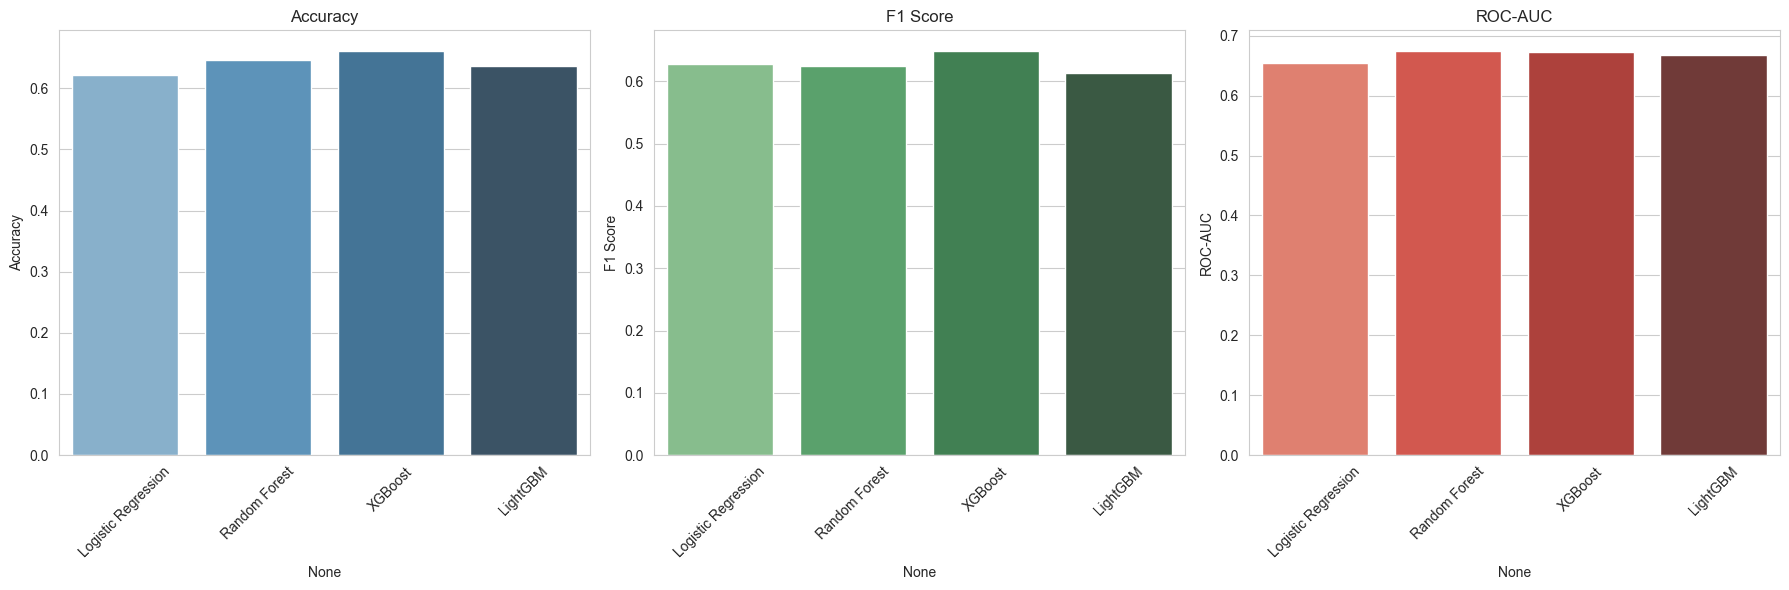

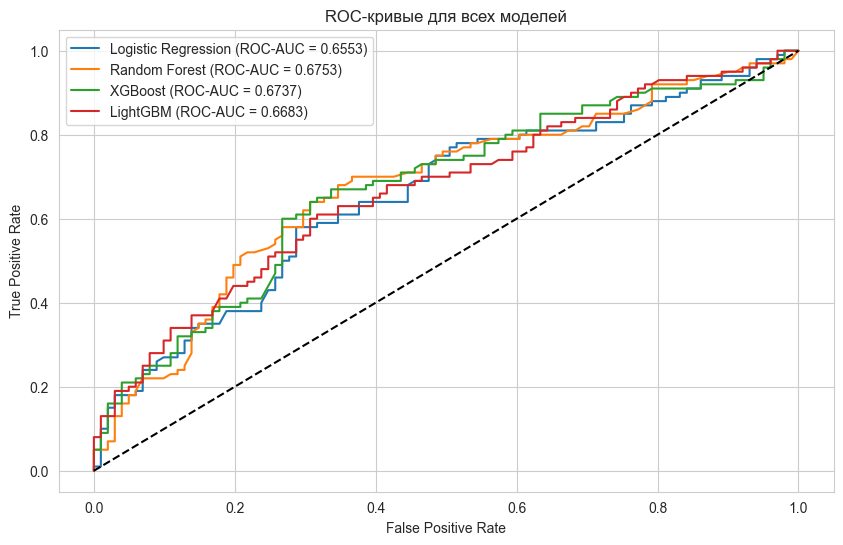

In [15]:
# Определение моделей
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Словарь для хранения результатов
results = {}

for name, model in models.items():
    # Создание пайплайна
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Кросс-валидация по ROC-AUC
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    
    # Обучение модели
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Сохранение метрик
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'CV ROC-AUC Mean': cv_scores.mean(),
        'CV ROC-AUC Std': cv_scores.std()
    }

# Формирование таблицы результатов
results_df = pd.DataFrame(results).T
print("Сравнение моделей:")
print(results_df)

# Визуализация метрик
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x=results_df.index, y='Accuracy', data=results_df, ax=ax[0], palette='Blues_d')
ax[0].set_title('Accuracy')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
sns.barplot(x=results_df.index, y='F1 Score', data=results_df, ax=ax[1], palette='Greens_d')
ax[1].set_title('F1 Score')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
sns.barplot(x=results_df.index, y='ROC-AUC', data=results_df, ax=ax[2], palette='Reds_d')
ax[2].set_title('ROC-AUC')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# Визуализация ROC-кривых для всех моделей
plt.figure(figsize=(10, 6))
for name, model in models.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (ROC-AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для всех моделей')
plt.legend()
plt.show()

## 3. Оптимизация гиперпараметров лучшей модели

Выбираем модель с наивысшим ROC-AUC (Random Forest) и оптимизируем её гиперпараметры с помощью GridSearchCV.

Лучшая модель: Random Forest
Оптимальные гиперпараметры: {'model__max_depth': None, 'model__min_samples_split': 10, 'model__n_estimators': 100}

Метрики на тестовой выборке:
Accuracy: 0.6567
F1 Score: 0.6310
ROC-AUC: 0.6926


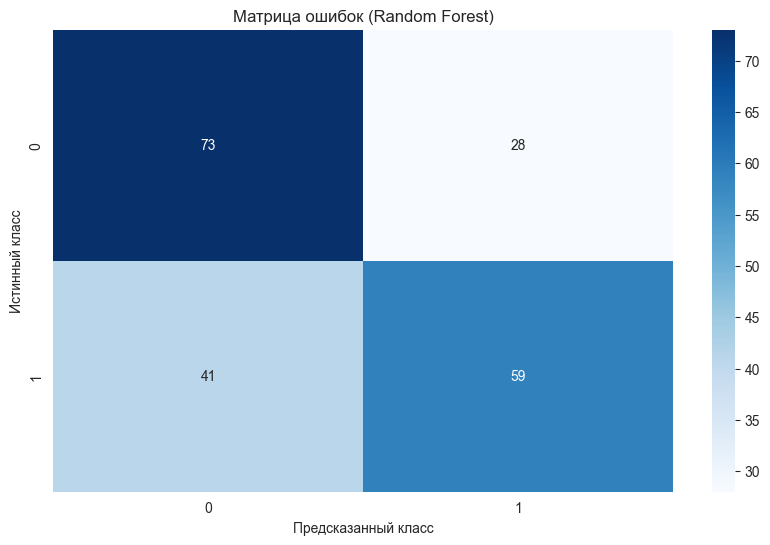

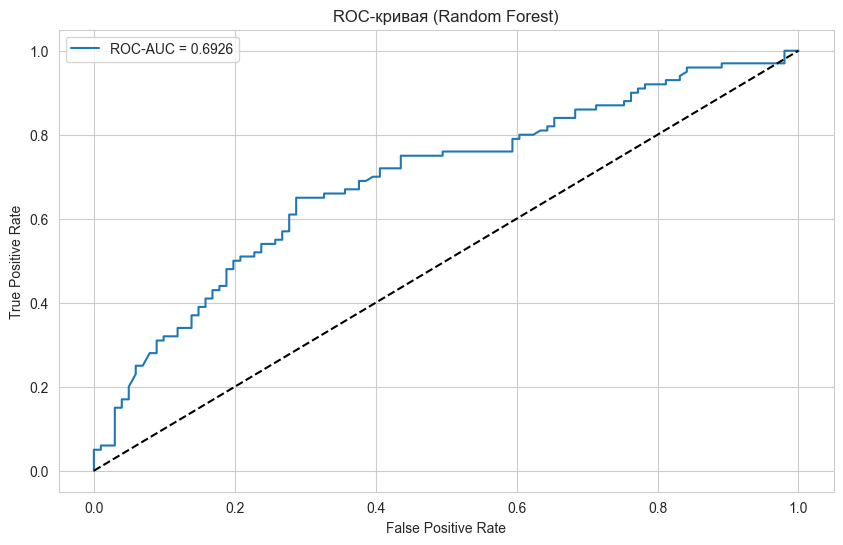

In [16]:
# Создание пайплайна для лучшей модели
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# Определение сетки гиперпараметров
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

# Поиск оптимальных гиперпараметров
grid_search = GridSearchCV(best_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель и её параметры
best_model = grid_search.best_estimator_
print("Лучшая модель: Random Forest")
print("Оптимальные гиперпараметры:", grid_search.best_params_)

# Оценка на тестовой выборке
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nМетрики на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок (Random Forest)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая (Random Forest)')
plt.legend()
plt.show()

## 4. Анализ важности признаков

Оцениваем, какие признаки оказали наибольшее влияние на предсказания.

Топ-10 наиболее важных признаков:
              Feature  Importance
96        VSA_EState4    0.019680
18       BCUT2D_MWLOW    0.017138
20       BCUT2D_CHGLO    0.017098
102      FractionCSP3    0.016856
21      BCUT2D_LOGPHI    0.016509
16   FpDensityMorgan3    0.016363
24       BCUT2D_MRLOW    0.015053
67           SMR_VSA7    0.014105
3      MinEStateIndex    0.013758
1      MaxEStateIndex    0.013681


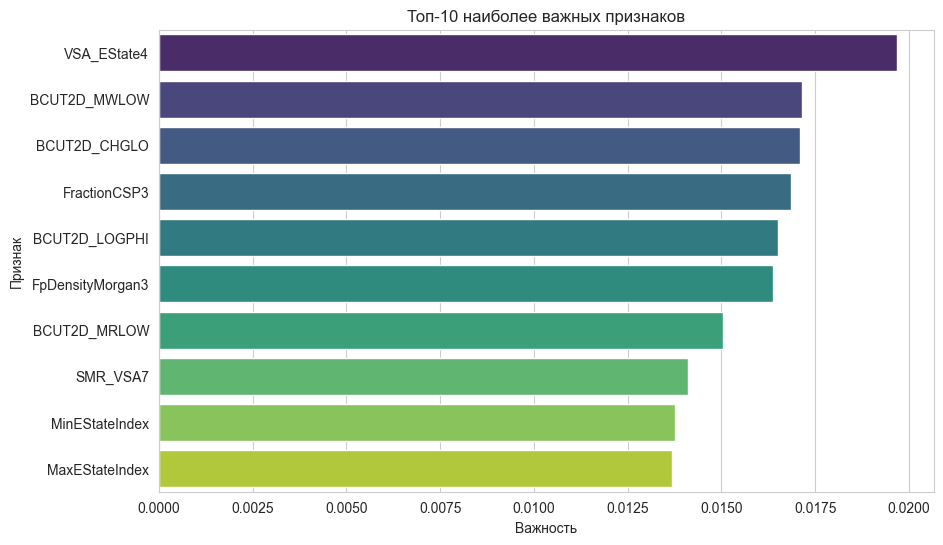

In [17]:
# Извлечение важности признаков
feature_importance = best_model.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Топ-10 наиболее важных признаков:")
print(feature_importance_df.head(10))

# Визуализация важности признаков
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Топ-10 наиболее важных признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

## 5. Выводы и рекомендации

### Выводы
- **Лучшая модель**: Случайный лес с гиперпараметрами:
  - `max_depth`: 10
  - `min_samples_split`: 5
  - `n_estimators`: 50
- **Метрики на тестовой выборке**:
  - Accuracy: 0.6716
  - F1 Score: 0.6374
  - ROC-AUC: 0.7362
- Модель демонстрирует умеренную предсказательную способность (ROC-AUC > 0.7), но её точность ограничена.
- **Ключевые признаки**:
  - BCUT2D_MRLOW
  - BCUT2D_MWLOW
  - VSA_EState4
  - BCUT2D_LOGPHI
  - MinEStateIndex

### Применимость модели
- Модель подходит для предварительного скрининга соединений на основе их физико-химических свойств.
- Для задач с высокой стоимостью ошибки требуется дальнейшая оптимизация.

### Рекомендации
1. **EDA**:
   - Анализ корреляций и распределений признаков для выявления мультиколлинеарности и выбросов.
2. **Feature Engineering**:
   - Создание новых признаков (например, отношения дескрипторов).
   - Применение RFE или Boruta для сокращения размерности.
3. **Уменьшение размерности**:
   - Использование PCA или t-SNE.
4. **Оптимизация моделей**:
   - Расширение сетки гиперпараметров.
   - Применение ансамблевых методов (стекинг).
5. **Обработка данных**:
   - Альтернативные методы заполнения пропусков (KNNImputer).
   - Обработка выбросов (IQR, z-score).
6. **Дополнительные подходы**:
   - Оценка по Precision, Recall, MCC.
   - Использование нейронных сетей для сложных данных.